In [2]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ieeg.auth import Session
from scipy import signal as sig
from scipy.integrate import simpson
from scipy.signal import coherence
from scipy.spatial.distance import pdist, squareform,cdist
from scipy.optimize import minimize

import scipy as sc
from bct.algorithms import community_louvain
plt.rcParams['image.cmap'] = 'BuPu'

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.utils import resample

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from pqdm.processes import pqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

import os
os.environ["ETS_TOOLKIT"] = "qt4"
os.environ["QT_API"] = "pyqt5"

/mnt/leif/littlab/users/wojemann/stim-seizures/stim_env-3_10/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading

In [3]:
metadata = pd.read_csv('../metadata_wchreject.csv')
# (metadata.cceps_hfs_seizure == 1) | 
metadata = metadata[(metadata.cceps_run1_sz == 1)].reset_index()
metadata.loc[:,'ieeg_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_phaseII'
metadata.loc[:,'ccep_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_CCEP'

In [4]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
prodatapath = CONFIG["paths"]["PROCESSED_DATA"]
ieeg_list = CONFIG["patients"]
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = np.unique(np.array([i.split("_")[0] for i in ieeg_list]))

In [5]:
pt = "HUP235"
raw_datapath = ospj(datapath,pt)


In [6]:
dirty_drop_electrodes = metadata[metadata.hupsubjno == int(pt[-3:])]["final_reject_channels"].str.split(',').to_list()[0]
if isinstance(dirty_drop_electrodes,list):
        final_drop_electrodes = clean_labels(dirty_drop_electrodes,pt)
else:
    final_drop_electrodes = []

In [7]:
seizure_list = np.sort([s for s in os.listdir(ospj(raw_datapath, "seizures")) if 'preprocessed' in s])

In [8]:
seizure_list

array(['preprocessed_seizure_0_stim_1.pkl',
       'preprocessed_seizure_10_stim_0.pkl',
       'preprocessed_seizure_11_stim_0.pkl',
       'preprocessed_seizure_1_stim_0.pkl',
       'preprocessed_seizure_2_stim_0.pkl',
       'preprocessed_seizure_3_stim_0.pkl',
       'preprocessed_seizure_4_stim_0.pkl',
       'preprocessed_seizure_5_stim_0.pkl',
       'preprocessed_seizure_6_stim_0.pkl',
       'preprocessed_seizure_7_stim_0.pkl',
       'preprocessed_seizure_8_stim_0.pkl',
       'preprocessed_seizure_9_stim_2.pkl'], dtype='<U34')

In [9]:
all_seizures = []
all_ts = []
for seizure_path in seizure_list:
    seizure_fs = pd.read_pickle(ospj(raw_datapath,"seizures",seizure_path))
    fs = seizure_fs.fs.to_numpy()[-1]
    seizure = seizure_fs.drop("fs",axis=1)
    cols = seizure.columns.to_list()
    clean_ch = [c for c in cols if c not in final_drop_electrodes]
    seizure = seizure.loc[:,clean_ch]
    t = np.arange(0,len(seizure)/fs,1/fs)
    all_ts.append(t)
    all_seizures.append(seizure)
    # plot_iEEG_data(seizure,t)


### Sandboxing DTW

#### Coh Generation

[[1.00000000e+00 3.73960505e-03]
 [2.00000000e+00 1.55701825e-02]
 [3.00000000e+00 2.62148008e-02]
 [4.00000000e+00 1.70438469e-02]
 [5.00000000e+00 4.64089588e-02]
 [6.00000000e+00 4.98411573e-02]
 [7.00000000e+00 6.63400011e-02]
 [8.00000000e+00 5.72068327e-02]
 [9.00000000e+00 4.76136330e-02]
 [1.00000000e+01 6.58744940e-02]
 [1.10000000e+01 9.24054340e-02]
 [1.20000000e+01 9.87024972e-02]
 [1.30000000e+01 9.15446394e-02]
 [1.40000000e+01 9.25029287e-02]
 [1.50000000e+01 9.54893027e-02]
 [1.60000000e+01 9.96013350e-02]
 [1.70000000e+01 1.03715131e-01]
 [1.80000000e+01 1.08775284e-01]
 [1.90000000e+01 1.18437436e-01]
 [2.00000000e+01 1.20243932e-01]
 [2.10000000e+01 1.27848680e-01]
 [2.20000000e+01 1.42120508e-01]
 [2.30000000e+01 1.58284180e-01]
 [2.40000000e+01 1.67582157e-01]
 [2.50000000e+01 1.76983245e-01]
 [2.60000000e+01 1.96848838e-01]
 [2.70000000e+01 2.06054618e-01]
 [2.80000000e+01 2.22503145e-01]
 [2.90000000e+01 2.29270101e-01]
 [3.00000000e+01 2.43480386e-01]]


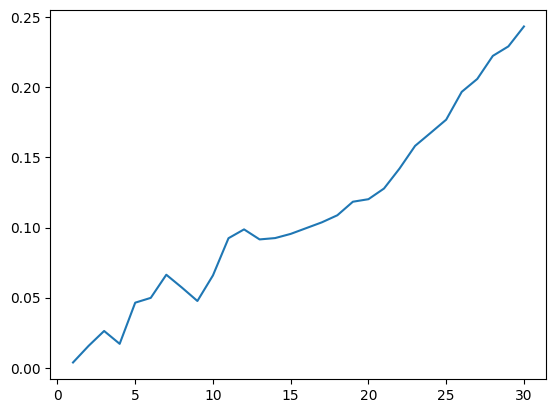

In [25]:
with open(ospj(prodatapath,f'stability_score_test.pkl'),'rb') as f:
    stability_scores = pickle.load(f)
scores = np.array(stability_scores)
plt.plot(scores[:,0],scores[:,1])
print(scores)

In [11]:
data = all_seizures[0]
factor = 2
win_len = 10
stride = 1

In [12]:
data = sig.decimate(data,factor,axis=0)
data = pd.DataFrame(data,columns=all_seizures[1].columns)
nfs = fs/factor

# Simulate a DataFrame
n_channels = data.shape[1]
m_samples = data.shape[0]

# Define frequency bands
freq_bands = [(1, 4), (4, 8), (8, 13), (13, 30), (30, 80), (80, 150)]

# Window parameters
window_length = int(win_len * nfs)
stride = int(stride*nfs)

# Initialize lists to hold results
all_coherences = []

# Loop through each window
for start in tqdm(range(0, m_samples - window_length + 1, stride)):
    window_data = data.iloc[start:start + window_length]
    coherence_matrix_list = []
    
    for low_f, high_f in freq_bands:
        coherences = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                f, Cxy = coherence(window_data.iloc[:, i], window_data.iloc[:, j], fs=fs)
                avg_coh = np.mean(Cxy[(f >= low_f) & (f <= high_f)])
                coherences.append(avg_coh)
        
        coherence_matrix_list.append(np.array(coherences))
    
    concatenated_coherence = np.concatenate(coherence_matrix_list)
    all_coherences.append(concatenated_coherence)
# Convert to NumPy array and L1 normalize
all_coherences = np.array(all_coherences)
all_coherences = normalize(all_coherences, norm='l1', axis=1)

100%|██████████| 57/57 [13:29<00:00, 14.19s/it]


In [78]:
# with open(ospj(prodatapath,f'all_coh_test_stim.pkl'),'wb') as f:
#     pickle.dump(all_coherences,f)
with open(ospj(prodatapath,f'all_coh_test_stim.pkl'),'rb') as f:
    all_coherences = pickle.load(f)

In [114]:
def _ccorr(X,Y):
            s = X.shape[1]
            out_mat = np.zeros((s,s))
            for x_i in range(s):
                for y_i in range(s):
                    c = np.corrcoef(X[:,x_i],Y[:,y_i])
                    out_mat[x_i,y_i] = c[0,1]
            return out_mat

_dissimilarity = lambda C,k: 1/(2*k)*(2*k - np.sum(np.max(C,axis=0)) - np.sum(np.max(C,axis=1)))

def stability_nmf(all_coherences,n_bootstrap=100,k_min = 5, k_max = 20):
    stability_scores = []

    for k in range(k_min, k_max + 1):
        D_list = []
        l_list = []
        for _ in range(int(n_bootstrap)):
            # Bootstrap resampling
            bootstrap_data = resample(all_coherences)
            
            # Perform NMF on bootstrap sample
            model = NMF(n_components=k, init='random', random_state=0)
            model.fit(bootstrap_data)
            D = model.components_
            l = model.reconstruction_err_

            # Sort each component by size and store
            D_list.append(D.T)
            l_list.append(l)
            
        D_array = np.array(D_list)
        # Calculate dissimilarity across Bootstraps
       
        # Cross-corr between columns of two different matrices
        
        # calculate dissimilarity for each combination of dictionaries at this k value
        diss_mat = np.zeros((n_bootstrap,n_bootstrap))
        for d_i in range(n_bootstrap):
            for d_j in range(n_bootstrap):
                C = _ccorr(D_array[d_i],D_array[d_j])
                diss_mat[d_i,d_j] = _dissimilarity(C,k)

        stability_score = np.mean(diss_mat[~np.eye(n_bootstrap,dtype=bool)])
        print(k,stability_score)
        stability_scores.append(stability_score)

    # Identify the number of components that gives the minimum stability score
    optimal_k = np.argmin(stability_scores) + 1
    model = NMF(n_components=optimal_k, init='random', random_state=0)
    W_optimal = model.fit_transform(all_coherences)
    H_optimal = model.components_
    recon_cohs = normalize(W_optimal@H_optimal,'l1',axis=1)
    return recon_cohs

In [115]:
stability_nmf(all_coherences,n_bootstrap=10,k_min=1,k_max=3)

1 0.005126308627390662
2 0.028176076662463783
3 0.00925388085405893


array([[7.11371140e-05, 5.88549713e-05, 6.39972530e-05, ...,
        1.85845059e-04, 1.32685179e-04, 1.69627899e-04],
       [7.11371140e-05, 5.88549713e-05, 6.39972530e-05, ...,
        1.85845059e-04, 1.32685179e-04, 1.69627899e-04],
       [7.11371140e-05, 5.88549713e-05, 6.39972530e-05, ...,
        1.85845059e-04, 1.32685179e-04, 1.69627899e-04],
       ...,
       [7.11371140e-05, 5.88549713e-05, 6.39972530e-05, ...,
        1.85845059e-04, 1.32685179e-04, 1.69627899e-04],
       [7.11371140e-05, 5.88549713e-05, 6.39972530e-05, ...,
        1.85845059e-04, 1.32685179e-04, 1.69627899e-04],
       [7.11371140e-05, 5.88549713e-05, 6.39972530e-05, ...,
        1.85845059e-04, 1.32685179e-04, 1.69627899e-04]])

In [113]:
# Stability-based NMF
n_bootstrap = 50  # Number of bootstrap samples
max_components = 7  # Maximum number of components to test
stability_scores = []

for k in range(1, max_components + 1):
    D_list = []
    l_list = []
    for _ in range(int(n_bootstrap)):
        # Bootstrap resampling
        bootstrap_data = resample(all_coherences)
        
        # Perform NMF on bootstrap sample
        model = NMF(n_components=k, init='random', random_state=0)
        model.fit(bootstrap_data)
        D = model.components_
        l = model.reconstruction_err_

        # Sort each component by size and store
        D_list.append(D.T)
        l_list.append(l)
        
    D_array = np.array(D_list)
    # Calculate dissimilarity across Bootstraps
    _diss = lambda C,k: 1/(2*k)*(2*k - np.sum(np.max(C,axis=0)) - np.sum(np.max(C,axis=1)))
    # Cross-corr between columns of two different matrices
    def _ccorr(X,Y):
        s = X.shape[1]
        out_mat = np.zeros((s,s))
        for x_i in range(s):
            for y_i in range(s):
                c = np.corrcoef(X[:,x_i],Y[:,y_i])
                out_mat[x_i,y_i] = c[0,1]
        return out_mat
    # calculate dissimilarity for each combination of dictionaries at this k value
    diss_mat = np.zeros((n_bootstrap,n_bootstrap))
    for d_i in range(n_bootstrap):
        for d_j in range(n_bootstrap):
            C = _ccorr(D_array[d_i],D_array[d_j])
            diss_mat[d_i,d_j] = _diss(C,k)

    stability_score = np.mean(diss_mat[~np.eye(n_bootstrap,dtype=bool)])
    print(k,stability_score)
    stability_scores.append(stability_score)

# Identify the number of components that gives the minimum stability score
optimal_k = np.argmin(stability_scores) + 1

1 0.007466576273210816


KeyboardInterrupt: 

In [105]:

# Perform NMF with optimal number of components
optimal_k = 2
model = NMF(n_components=optimal_k, init='random', random_state=0)
W_optimal = model.fit_transform(all_coherences)
H_optimal = model.components_

In [106]:
manual_cohs = normalize(W_optimal@H_optimal,'l1',axis=1)

#### Coh Analysis

In [107]:
# with open(ospj(prodatapath,pt,f'{pt}_seizure_networks.pkl'),'rb') as f:
#     coh_struct = pickle.load(f)
# with open(ospj(prodatapath,pt,f'script_test_networks.pkl'),'rb') as f:
#         test_cohs= pickle.load(f)

In [108]:
# coh_struct
# [i[0] for i in coh_struct['seizure_networks']]
# recon_cohs = [i[1] for i in coh_struct['seizure_networks']]

#### MDS Coh Plotting

In [109]:
def sammon(X, max_iter=1e10, tol=1e-5):
    pairwise_dissimilarities = squareform(pdist(X, metric='cityblock'))  # Using L1 distance
    plt.imshow(pairwise_dissimilarities)
    init = np.random.rand(X.shape[0], 2)  # Random 2D initialization
    
    def stress(Y):
        Y = Y.reshape((X.shape[0], 2))
        d = squareform(pdist(Y))
        d[d == 0] = 1  # Prevent division by zero
        ratio = pairwise_dissimilarities / d
        return np.sum((pairwise_dissimilarities - d)**2 * ratio)
    
    res = minimize(stress, init.ravel(), method='L-BFGS-B', tol=tol, options={'maxiter': max_iter, 'disp': False})
    return res.x.reshape((X.shape[0], 2))


### Fridge Network Clustering

In [110]:
# n1=0
# n2=0
# s1 = recon_cohs[n1]
# s2 = recon_cohs[n2]
# seizure_comparison = 1-cdist(s1,s2,metric='cityblock')
# seizure_clustering = 1-squareform(pdist(recon_cohs[11],'cityblock'))
# plt.imshow(seizure_clustering)

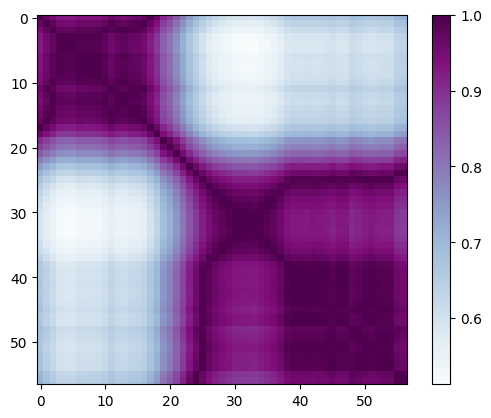

In [111]:
# seizure_clustering = 1-squareform(pdist(manual_cohs,'cityblock'))
s1=s2=manual_cohs.T
seizure_clustering = np.zeros((s1.shape[1],s2.shape[1]))
for i in range(s1.shape[1]):
    for j in range(s2.shape[1]):
        c = np.corrcoef(s1[:,i],s2[:,j])
        c_element = np.abs(c[0,1]) * (1-0.01*np.abs(i-j)/s1.shape[0])
        seizure_comparison[i,j] = c_element
plt.imshow(seizure_clustering)
plt.colorbar()

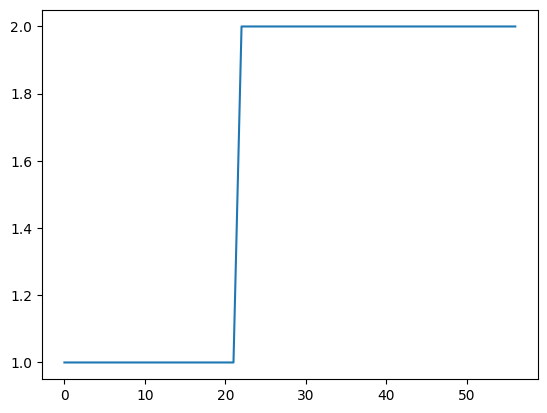

In [112]:
all_ass = []
for s in range(50):
    assignments,_ = community_louvain(seizure_clustering,.95,seed=s)
    all_ass.append(assignments)
all_ass = np.array(all_ass)
raw_assignments,_ = sc.stats.mode(all_ass,axis=0)
filt_assignments = sig.medfilt(raw_assignments,7)
plt.plot(raw_assignments)

In [87]:
# fig,ax = plt.subplots()
# divider = make_axes_locatable(ax)
# ax_signal = divider.append_axes("top", size="5%", pad=0.5)

# # Plot the cluster assignment signal (you can adjust this part to fit your specific needs)
# ax_signal.imshow(raw_assignments[np.newaxis, :], cmap='coolwarm', aspect='auto')
# ax_signal.axis('off')
# ax.imshow(seizure_comparison)
# plt.colorbar()

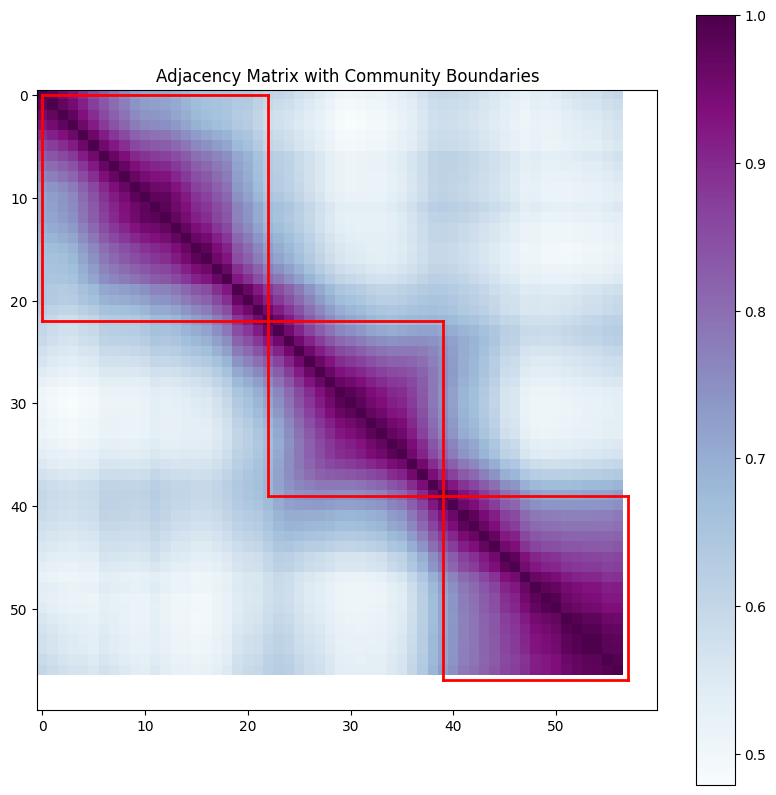

In [88]:
plt.figure(figsize=(10, 10))
order = np.argsort(raw_assignments)

plt.imshow(seizure_clustering)
plt.colorbar()
# Drawing the community boundaries
current_x = 0

for module in np.unique(raw_assignments):
    size = np.sum(filt_assignments[order] == module)
    plt.plot([current_x, current_x + size], [current_x, current_x], 'r', linewidth=2)
    
    # Left boundary
    plt.plot([current_x, current_x], [current_x, current_x + size], 'r', linewidth=2)
    
    # Bottom boundary
    plt.plot([current_x, current_x + size], [current_x + size, current_x + size], 'r', linewidth=2)
    
    # Right boundary
    plt.plot([current_x + size, current_x + size], [current_x, current_x + size], 'r', linewidth=2)
    
    current_x += size


plt.title('Adjacency Matrix with Community Boundaries')
plt.show()


#### Fridge DTW

### Graveyard

In [72]:
recon_cohs = normalize(W_optimal@H_optimal,'l1',axis=1)

In [ ]:
def calculate_coh_timeseries(data,fs=1024,win_len=10,stride=1,factor=2,freq_bands=[(1, 4), (4, 8), (8, 13), (13, 30), (30, 80), (80, 150)]):
    data = sig.decimate(data,factor,axis=0)
    data = pd.DataFrame(data,columns=all_seizures[1].columns)
    nfs = fs/factor

    # Simulate a DataFrame
    n_channels = data.shape[1]
    m_samples = data.shape[0]

    # Define frequency bands
    freq_bands = [(1, 4), (4, 8), (8, 13), (13, 30), (30, 80), (80, 150)]

    # Window parameters
    window_length = int(win_len * nfs)
    stride = int(stride*nfs)

    # Initialize lists to hold results
    all_coherences = []

    # Loop through each window
    for start in tqdm(range(0, m_samples - window_length + 1, stride)):
        window_data = data.iloc[start:start + window_length]
        coherence_matrix_list = []
        
        for low_f, high_f in freq_bands:
            coherences = []
            for i in range(n_channels):
                for j in range(i+1, n_channels):
                    f, Cxy = coherence(window_data.iloc[:, i], window_data.iloc[:, j], fs=fs)
                    avg_coh = np.mean(Cxy[(f >= low_f) & (f <= high_f)])
                    coherences.append(avg_coh)
            
            coherence_matrix_list.append(np.array(coherences))
        
        concatenated_coherence = np.concatenate(coherence_matrix_list)
        all_coherences.append(concatenated_coherence)
    # Convert to NumPy array and L1 normalize
    all_coherences = np.array(all_coherences)
    all_coherences = normalize(all_coherences, norm='l1', axis=1)
    return all_coherences


In [ ]:
def nonstationary_bandpower(x: np.ndarray, fs: float, lo_stop=1, hi_stop=120, relative=True, win_size=2, win_stride=1) -> np.array:
    """
    Calculates the relative bandpower of a signal x, using a butterworth filter of order 'order'
    and bandpass filter between lo and hi Hz.

    Use scipy.signal.welch and scipy.integrate.simpson
    """
    
    bands = {"delta": (1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
    bands = {"broad": (6,100)}
    nperseg = int(win_size * fs)
    noverlap = nperseg - int(win_stride * fs)

    # freq, pxx = sig.welch(x=x, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)
    freq,t,Sxx = sig.spectrogram(x=x,fs=fs,nperseg=nperseg,noverlap=noverlap,axis=1)
    filter_idxs = (freq > lo_stop) & (freq < hi_stop)
    # log transform the power spectrum
    # pxx = 10*np.log10(pxx)
    
    all_bands = np.zeros((Sxx.shape[0],len(bands),Sxx.shape[2]))
    for i, (_, (lo, hi)) in enumerate(bands.items()):
        idx_band = np.logical_and(freq >= lo, freq <= hi)
        bp = simpson(Sxx[:, idx_band,:], dx=freq[1] - freq[0],axis=1)
        # relative
        if relative:
            bp /= simpson(Sxx[:,filter_idxs,:], dx=freq[1] - freq[0],axis=1)
        all_bands[:, i,:] = bp
    return all_bands,t
    # return bp
    # return data_filt
bp = nonstationary_bandpower(seizure.to_numpy().T,fs)

In [ ]:
seizure_signals,_ = [nonstationary_bandpower(x.T,fs,win_size=1,win_stride=.5,relative=True).squeeze() for x in all_seizures];

NameError: name 'all_seizures' is not defined

In [143]:
s1 = recon_cohs[0].T
s2 = recon_cohs[0].T
seizure_comparison = np.zeros((s1.shape[1],s2.shape[1]))
for i in range(s1.shape[1]):
    for j in range(s2.shape[1]):
        c = np.corrcoef(s1[:,i],s2[:,j])
        c_element = np.abs(c[0,1]) * (1-0.2*np.abs(i-j)/s1.shape[0])
        seizure_comparison[i,j] = c_element

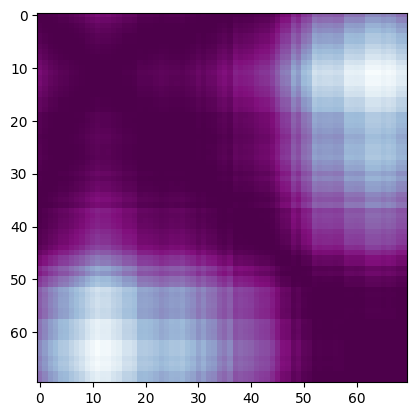

In [144]:
plt.imshow(seizure_comparison)